# Regression Regularization Techniques - Ridge and Lasso Regression

In this notebook we'll build upon what we learned in Notebook 5. How can we address things like overfitting and collinearity? One approach is through regularization.

## What We'll Accomplish in This Notebook

In particular we'll:

<ul>
    <li>See what happens to our coefficients when we overfit with a polynomial regression example,</li>
    <li>Introduce the main framework behind regularization,</li>
    <li>Discuss how Ridge and Lasso regression work and apply it to our polynomial regression problem,</li>
    <li>See hyperparameters for the first time,</li>
    <li>Learn about scaling data,</li>
    <li>Learn how to use Lasso for feature selection.</li>
</ul>

In [1]:
# import the packages we'll use
## For data handling
import pandas as pd
import numpy as np
from numpy import meshgrid

## For plotting
import matplotlib.pyplot as plt
import seaborn as sns

## This sets the plot style
## to have a grid on a white background
sns.set_style("whitegrid")

## Coefficient Explosions

Let's return to our example from Notebook 5.

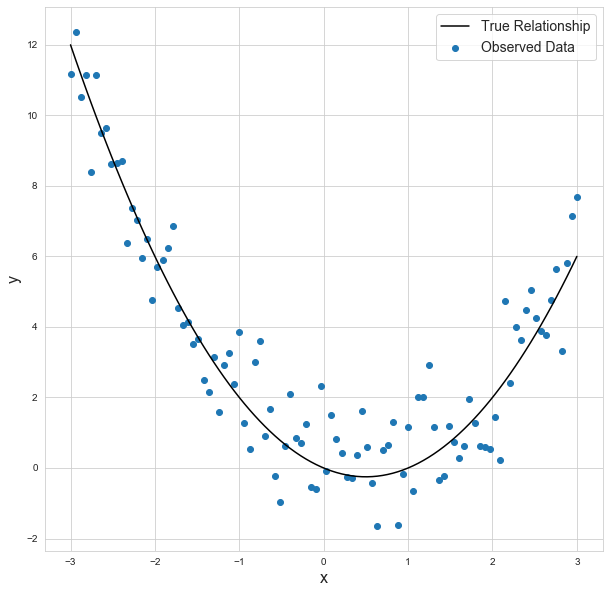

In [2]:
x = np.linspace(-3,3,100)
y = x*(x-1) + 1.2*np.random.randn(100)

plt.figure(figsize = (10,10))

plt.scatter(x,y, label="Observed Data")

plt.plot(x,x*(x-1),'k', label="True Relationship")

plt.xlabel("x",fontsize=16)
plt.ylabel("y",fontsize=16)

plt.legend(fontsize=14)

plt.show()

In [3]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

In [4]:
n = 26
coef_holder = np.zeros((n,n))

In [5]:
# Now we'll fit the data with polynomials degree 1 through n
for i in range(1,n+1):
    # Make a pipe
    pipe = Pipeline([('poly',PolynomialFeatures(i,include_bias = False)),
                    ('reg',LinearRegression())])
    
    # fit the data
    pipe.fit(x.reshape(-1,1),y)
    
    # store the coefficient estimates
    coef_holder[i-1,:i] = np.round(pipe['reg'].coef_,3)

In [6]:
# Display the coefficient estimates as a dataframe
pd.DataFrame(coef_holder, 
             columns = ["x^" + str(i) for i in range(1,n+1)],
            index = [str(i) + "_deg_poly" for i in range(1,n+1)])

,x^1,x^2,x^3,x^4,x^5,x^6,x^7,x^8,x^9,x^10,...,x^17,x^18,x^19,x^20,x^21,x^22,x^23,x^24,x^25,x^26
1_deg_poly,-0.926,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.0
2_deg_poly,-0.926,0.963,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.0
3_deg_poly,-0.993,0.963,0.012,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.0
4_deg_poly,-0.993,0.745,0.012,0.028,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.0
5_deg_poly,-0.769,0.745,-0.102,0.028,0.011,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.0
6_deg_poly,-0.769,0.676,-0.102,0.050,0.011,-0.002,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.0
7_deg_poly,-0.711,0.676,-0.159,0.050,0.025,-0.002,-0.001,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.0
8_deg_poly,-0.711,0.720,-0.159,0.024,0.025,0.003,-0.001,-0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.0
9_deg_poly,-0.343,0.720,-0.749,0.024,0.276,0.003,-0.040,-0.000,0.002,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.0
10_deg_poly,-0.343,1.753,-0.749,-0.954,0.276,0.324,-0.040,-0.043,0.002,0.002,...,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.0


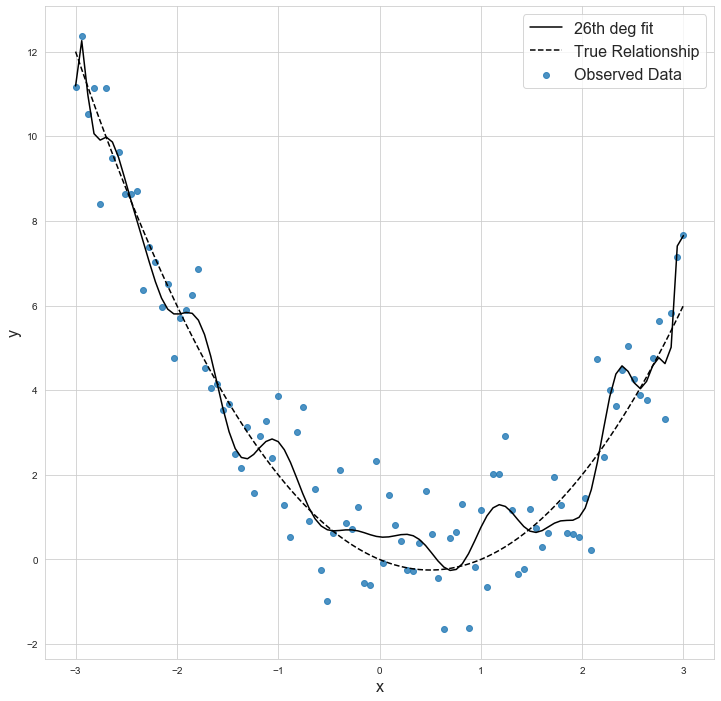

In [7]:
# plot to remind ourselves of the overfitting
plt.figure(figsize=(12,12))

plt.scatter(x, y, alpha = .8, label="Observed Data")

plt.plot(x,
         pipe.predict(x.reshape(-1,1)),
         'k', label= str(n) + "th deg fit")

plt.plot(x,x*(x-1),'k--',label = "True Relationship")

plt.xlabel("x",fontsize=16)
plt.ylabel("y",fontsize=16)

plt.legend(fontsize=16)

plt.show()

Looking at the dataframe we've just produced we can notice that a number of our coefficients get larger in magnitude as the model gets more complex. 

This observation leads to the main idea behind regularization.

## The Idea Behind Regularization

Suppose the non-intercept coefficients from the regression are denoted by $\beta$, i.e. $\beta=\left(\beta_1,\beta_2,\dots,\beta_m\right)^T$. Recall that in Ordinary Least Squares regression our goal is to estimate $\beta$ so that
$$
MSE = \frac{1}{n}(y - X\beta - \beta_0)^T(y - X\beta - \beta_0)
$$
is minimized on the training data.

The main idea behind regularization is to still minimize the MSE, BUT while also ensuring that $\beta$ doesn't get too large. 

#### How to Measure Large?

It's reasonable to wonder how we can measure largeness of $\beta$. Let $||\bullet||$ denote some norm in $\mathbb{R}^{m+1}$. If you're unfamiliar with what a norm is don't worry we'll make this more concrete when we talk about lasso and ridge regression, for now think of it as a measure of how "long" the $\beta$ vector is. We measure how large $\beta$ is by looking at $||\beta||$.

#### Constrained Optimization

In regularization we still minimize the MSE, but we constrain ourselves so that we only consider $\beta$ with $||\beta||\leq c$ for some constant $c$. 

#### An Equivalent Problem

It turns out this is equivalent to minimizing the following: 
$$
||y-X\beta - \beta_0||^2_2 + \alpha||\beta||,
$$
for some constant $\alpha$ and where $||a||_2^2 = a_1^2 + a_2^2 + \dots + a_n^2, a\in\mathbb{R}^n$. Note that minimizing $||y-X\beta - \beta_0||^2_2$ is equivalent to minimizing the MSE. 

To see a mathematical derivation of this equivalence look at reference 3 below.

Here we can think of $\alpha||\beta||$ as a penalty term, which will not allow $\beta$ to grow too large as we minimize $||y-X\beta-\beta_0||^2_2$. The ammount we "penalize" for a large $\beta$ depends on the value of $\alpha$. 

#### Our First Hyperparameter

$\alpha$ is the first instance in our course of a <i>hyperparameter</i>, but it will not be the last. A hyperparameter is a parameter we set before fitting the model. While normal parameters, like $\beta$, are estimated during the training step.

For $\alpha=0$ we recover the OLS estimate for $\beta$, for $\alpha=\infty$ we get $\beta=0$, values of $\alpha$ between those two extremes will give different coefficient estimates. The value of $\alpha$ that gives the best model for your data depends on the problem and can be found through cross-validation model comparisons.


## Ridge and Lasso

<i>Ridge regression</i> and <i>lasso</i> are two forms of regularization where we make specific choices for the norm:
<ul>
    <li>In ridge regression we take $||\bullet||$ to be the square of the Euclidean norm, $||\bullet||_2^2$,</li>
    <li>In lasso we take $||\bullet||$ to be the $l_1$-norm, $||a||_1 = |a_1| + |a_2| + \dots + |a_n|, \ a\in \mathbb{R}^n$.
</ul>

### Containing the Explosion of $\beta$

These two algorithms make it difficult for $\beta$ to explode. Let's use ridge regression on our polynomial example above and track the norm of $\beta$ as we increase $\alpha$.

In [8]:
# the ridge regression object is called Ridge in 
# sklearn.linear_model
from sklearn.linear_model import Ridge

In [9]:
# make an array of lambda values
alphas = np.arange(0,.001,.000001)
norms = []

# for each alpha value
for a in alphas:
    # We'll talk about normalizing in a second
    pipe = Pipeline([('poly',PolynomialFeatures(30, include_bias=False)),
                    ('ridge',Ridge(alpha=a, normalize=True))])
    
    pipe.fit(x.reshape(-1,1),y)
    
    
    # get the beta vector
    coefs = pipe['ridge'].coef_
    
    # append the square of 2-norm of beta for this alpha
    norms.append(np.power(np.sqrt(np.sum(np.power(coefs,2))),2))

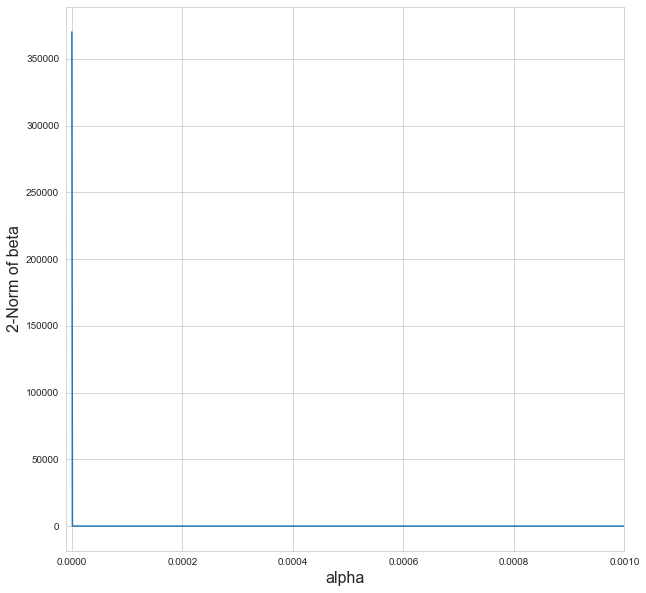

In [10]:
# now plot
plt.figure(figsize=(10,10))

plt.plot(alphas,norms)

plt.xlabel("alpha",fontsize=16)
plt.ylabel("2-Norm of beta",fontsize=16)

plt.xlim((-.00001,max(alphas)))

plt.show()

## Practice

### A Quick Aside on "Normalizing"

These regularization techniques are very sensitive to the scale of our predictors. This is a result of the constrained optimization set up of the problem. To illustrate this let's look at an example.

Suppose someone's tiredness after a walk is given by:
$$
\text{tiredness} = \text{age} + 3\text{(distance traveled in m)}
$$

We'll use this breakout session to explore what happens in ridge regression and lasso when we go between measuring distnace on two different scales, meters and kilometers.

Take the given data and assume age is in years and distance is in meters.

In [11]:
age = np.random.randint(20,40,100)
distance = 3*np.random.randn(100)+10

tiredness = age +  3*distance + 2*np.random.randn(100)

df = pd.DataFrame({'age':age,'distance':distance,'tiredness':tiredness})

Now build a linear regression model of `tiredness` on `age` and `distance`. Print the coefficients.

Then create a new column in the dataframe changing `distance` to being measured in kilometers, call it `distance_km`. Fit a second model regressing `tiredness` on `age` and `distance_km`. Again print the coefficients.

In [12]:
## Code here














In [13]:
## Code here














Now build a ridge regression model again regressing `tiredness` on `age` and `distance`. Let $\alpha=10$, but do NOT include `normalize=True`. Print the coefficients. How do these compare to the normal linear regression model?


Then build a ridge regression model using the `distance_km` instead of `distance`. Again do NOT include `normalize=True`. Let $\alpha=10$, and print the coefficients what happened this time?

In [14]:
## Code here














In [15]:
## Code here














As $\alpha$ increases in ridge and lasso our "budget" for the constrained optimization gets smaller, meaning that we can't appropriately estimate the coefficient on distance when it is measured in kilometers. This is due to the large difference in scales between meters and kilometers.

#### How to Solve the Scaling Issue?

One way to address the scale issue is to just adjust all of our features to have the same scale prior to fitting the model. We can do this by setting `normalize=True` in the `Ridge` and `Lasso` model objects. This centers and scales the features by subtracting off their mean and dividing by their $l_2$ norms.

Refit the two ridge models you just created, this time set `normalize = True`. What happened?

In [16]:
## Code here














In [17]:
## Code here














#### Standardizing by Hand

Another way to scale down the data is to use `sklearn`'s `StandardScaler`. This is a method that scales the data to have mean $0$ and variance $1$ using the standard normal transformation:
$$
\frac{X - \overline{X}}{s_X}.
$$
While slightly different than `normalize=True` it still puts all of the data on the same scale and can be used instead of `normalize=True`.

Build a pipe that first takes the data and scales it using `StandardScaler` then fits the ridge regression with $\alpha=10$. This time remember to set `normalize=False` or just leave the `normalize` option out of the model object.

In [18]:
## import standard scaler
from sklearn.preprocessing import StandardScaler

# you make a scaler object like StandarScaler()

In [19]:
## Code here














In [20]:
## Code here














A quick note before moving on.

`StandardScaler` has the following methods:
- `fit` which uses the input data to fit the method, i.e. find the mean and standard deviation of the input data
- `transform` which uses the statistics calculated in `fit` to scale the input data
- `fit_transform` which fits and transforms all in one.

##### Why is this Important?

This is important because the order in which we do things matters. We first `fit` the scaler using the training data, this sets the scaler for all future data we put into the `transform` method, training and testing. The main take away here is that the scaler fit from the training data is the fit we use to predict on the testing data. This is a subtle distinction, but an important one.

Okay now time to talk about lasso.

## Looking More Closely at Lasso

Up to this point we've mainly focused on ridge regression. Let's look more closely at lasso now.

As we've said the formulation of lasso is identical to that of ridge regression up to the choice of norm. Looking at the two norms $||\bullet||_2^2$ for ridge and $||\bullet||_1$ for lasso the main difference is that the square of the $l_2$ norm is differentiable everywhere, where as the $l_1$ norm is not.

### Lasso for Feature Selection

This fact gives lasso one of its best uses, feature selection. Let's return to our polynomial again.

In [21]:
x = np.linspace(-3,3,100)
y = x*(x-1) + 1.2*np.random.randn(100)

We'll fit this with a high degree polynomial, after normalizing of course, with both ridge and lasso models but for different values of $\alpha$.

In [22]:
from sklearn.linear_model import Lasso

In [23]:
alpha = [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000]

n=10

# These will hold our coefficient estimates
ridge_coefs = np.empty((len(alpha),n))
lasso_coefs = np.empty((len(alpha),n))

# for each alpha value
for i in range(len(alpha)):
    # set up the ridge pipeline
    ridge_pipe = Pipeline([('poly',PolynomialFeatures(n,include_bias=False)),
                          ('ridge',Ridge(alpha = alpha[i], normalize=True))])
    
    # set up the lasso pipeline
    lasso_pipe = Pipeline([('poly',PolynomialFeatures(n,include_bias=False)),
                          ('lasso',Lasso(alpha = alpha[i], normalize=True, max_iter = 1000000))])
    
    # fit the ridge
    ridge_pipe.fit(x.reshape(-1,1),y)
    
    # fit the lasso
    lasso_pipe.fit(x.reshape(-1,1),y)
    
    # record the coefficients
    ridge_coefs[i,:] = ridge_pipe['ridge'].coef_
    lasso_coefs[i,:] = lasso_pipe['lasso'].coef_

In [24]:
print("Ridge Coefficients")

pd.DataFrame(np.round(ridge_coefs,8),
            columns = ["x^" + str(i) for i in range(1,n+1)],
            index = ["alpha=" + str(a) for a in alpha])

Ridge Coefficients


,x^1,x^2,x^3,x^4,x^5,x^6,x^7,x^8,x^9,x^10
alpha=1e-05,-1.293120,0.347726,0.277220,0.171084,-0.057808,-0.006443,0.003385,-0.002189,-3.571000e-05,1.873100e-04
alpha=0.0001,-1.216753,0.416948,0.183583,0.146786,-0.024788,-0.007162,-0.001076,-0.001294,1.694600e-04,1.190900e-04
alpha=0.001,-1.080191,0.589814,0.083996,0.070399,-0.008931,-0.000938,-0.000988,-0.000379,7.511000e-05,1.810000e-05
alpha=0.01,-0.904039,0.627994,-0.001441,0.043693,-0.001024,0.001505,-0.000222,-0.000063,-1.819000e-05,-1.661000e-05
alpha=0.1,-0.651807,0.514038,-0.039657,0.036775,-0.002298,0.002096,-0.000113,0.000058,-1.420000e-06,-8.260000e-06
alpha=1,-0.304878,0.246787,-0.033695,0.023465,-0.003267,0.002198,-0.000311,0.000205,-2.940000e-05,1.911000e-05
alpha=10,-0.077986,0.070045,-0.011614,0.008078,-0.001412,0.000910,-0.000163,0.000101,-1.835000e-05,1.113000e-05
alpha=100,-0.010129,0.009387,-0.001591,0.001117,-0.000200,0.000129,-0.000024,0.000015,-2.700000e-06,1.630000e-06
alpha=1000,-0.001046,0.000973,-0.000165,0.000116,-0.000021,0.000013,-0.000002,0.000002,-2.800000e-07,1.700000e-07


In [25]:
print("Lasso Coefficients")

pd.DataFrame(np.round(lasso_coefs,8),
            columns = ["x^" + str(i) for i in range(1,n+1)],
            index = ["alpha=" + str(a) for a in alpha])

Lasso Coefficients


,x^1,x^2,x^3,x^4,x^5,x^6,x^7,x^8,x^9,x^10
alpha=1e-05,-1.244373,0.346129,0.212958,0.184990,-0.033855,-0.013748,0.000000,-0.000959,0.000126,0.000122
alpha=0.0001,-1.064660,0.615901,0.076168,0.058567,-0.011204,-0.000000,-0.000000,-0.000212,0.000000,0.000000
alpha=0.001,-0.932970,0.721278,-0.000000,0.032102,-0.000000,0.000000,-0.000286,-0.000000,-0.000020,-0.000000
alpha=0.01,-0.888539,0.704445,-0.000000,0.030062,-0.001015,0.000000,-0.000264,0.000000,-0.000000,0.000000
alpha=0.1,-0.478732,0.537136,-0.000000,0.009539,-0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000
alpha=1,-0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000
alpha=10,-0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000
alpha=100,-0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000
alpha=1000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000


If we look at our two tables we see that the ridge coefficients slowly go down to $0$, but most of the time don't actually get there. On the other hand for lasso with $\alpha=0.1$ almost all of our coefficients are $0$, except for the ones that matter the coefficients for $x$ and $x^2$.

This feature of lasso makes it quite popular, particularly when you have a lot of features which makes other popular model selection algorithms unfeasible (see Regression HW).

You just fit a lasso model with all of your features and then choose the ones that are nonzero for your final model. Again this should be done with some sort of test to see which model you think will give the better test error, like cv.

### Why Does it Do That?

To see a geometric explanation for why this happens let's return to our constrained optimization formulation, and assume both $X$ and $y$ have mean $0$ for simplicity.

##### Ridge Regression
$$
\text{Minimize } || y - X\beta||_2^2 \text{ constrained to } ||\beta||_2^2 \leq c.
$$

If we have two features the constraint is $\beta_1^2 + \beta_2^2 \leq (\sqrt{c})^2$, which you may recall is the formula for a filled in circle centered at the origin with radius $\sqrt{c}$ in $\mathbb{R}^2$.

##### Lasso
$$
\text{Minimize } || y - X\beta||_2^2 \text{ constrained to } ||\beta||_1 \leq c.
$$

If we have two features the constraint is $|\beta_1| + |\beta_2| \leq c$, which gives a filled in square with edges at $(c,0),(0,c),(-c,0),$ and $(0,-c)$.

Let's look at a picture in the case of two features.
<img src="lasso_ridge_eosl.png" style="width:60%"></img>
Photo Credit to <a href="https://web.stanford.edu/~hastie/ElemStatLearn/">Elements of Statistical Learning</a>.

In this photo $\hat{\beta}$ is the OLS estimate for $\beta$ at the minimum value of $|| y - X\beta||_2^2$, the red ellipses are selected level curves for $|| y - X\beta||_2^2$, and the blue square and circle are the contraint regions for the lasso and ridge respectively. We can think of lasso and ridge as finding the smallest level curve that still intersects with the constraint region. If the OLS estimate is not contained within the constraint region this will occur somewhere on the boundary. This image demonstrates that the level curve corresponding to the minimal value of $|| y - X\beta||_2^2$ often intercepts the lasso constraint on an axis of the $\beta$-space, which is not the case for ridge regression.

As a reminder for practical purposes decreasing the value of $\alpha$ for the `sklearn` `Lasso` and `Ridge` objects increases the size of the constraint region. Increasing the value of $\alpha$ will shrink the constraint region.

## Questions

That may have been a bit confusing, let's take one or two questions then you'll use Lasso for some feature selection.


<br>
<br>
<br>
<br>
<br>
<br>

## End Questions

## Practice


Run the following code to generate data `X` and `y`.

Use lasso to try and determine which features should be included in the model. When you're ready run the code block at the end to see how the data was constructed.

In [26]:
import generate as g

In [27]:
X,y = g.get_data()

In [28]:
## Code here













In [29]:
## Code here














In [30]:
## Code here














In [31]:
## Code here














In [32]:
g.give_how_generated()

The data was generated using the following code.
    X = np.random.randn(500,30)
    
    X[:,0] = 2000*X[:,0] + 5000
    X[:,1] = 100*X[:,1] - 20
    X[:,7] = 50*X[:,7]+120 - 10*X[:,3]
    
    y = 2*X[:,0] - 3*X[:,1] + X[:,7] + 20*np.random.randn(500)


## Which One is Better?

Which algorithm is the better choice? Well that depends on the problem. Both are good at addressing overfitting concerns, but each has a couple unique pros and cons.

##### Lasso

<b>Pros</b>

<ul>
    <li>Works well when you have a large number of features that don't have any effect on the target.</li>
    <li>Feature selection is a plus, this can allow for a sparser model which is good for computational reasons.</li>
</ul>

<b>Cons</b>

<ul>
    <li>Can have trouble with highly correlated features, it typically chooses one variable among those that are correlated, which may be random.</li>
</ul>


##### Ridge

<b>Pros</b>

<ul>
    <li>Works well when the target depends on all or most of the features.</li>
    <li>Can handle colinearity better than lasso.</li>
</ul>

<b>Cons</b>

<ul>
    <li>Because ridge typically keeps most of the predictors in the model, this can be a computationally costly model type for data sets with a large number of predictors.</li>
</ul>


##### Elastic Net

Sometimes the best model will be something in between ridge and lasso. Check out the Regression HW to learn about how that is possible with an elastic net model.

## Questions

We'll answer a couple of questions.

<br>
<br>
<br>
<br>
<br>

## End Questions

That's it for this notebook and for regression lessons! For our final regression notebooks you'll be in charge of building a model to predict Boston Housing Values. In Notebook 7 you'll see an example of the entire model building process using California housing data. You can use this as a guide to work through Notebook 8.

## Notebook Specific References

To help teach this lesson I consulted some additional source I found through a Google search. Here are links to those references for you to take a deeper dive into ridge and lasso regression.

<ol>
    <li><a href="http://faculty.marshall.usc.edu/gareth-james/ISL/">http://faculty.marshall.usc.edu/gareth-james/ISL/</a></li>
    <li><a href="https://www.analyticsvidhya.com/blog/2016/01/ridge-lasso-regression-python-complete-tutorial/">https://www.analyticsvidhya.com/blog/2016/01/ridge-lasso-regression-python-complete-tutorial/</a></li>
    <li><a href="https://suzyahyah.github.io/math/optimization/2018/07/20/Constrained-unconstrained-form-Ridge.html">https://suzyahyah.github.io/math/optimization/2018/07/20/Constrained-unconstrained-form-Ridge.html</a></li>
    <li><a href="https://statweb.stanford.edu/~owen/courses/305a/Rudyregularization.pdf">https://statweb.stanford.edu/~owen/courses/305a/Rudyregularization.pdf</a></li>
    <li><a href="http://web.mit.edu/zoya/www/linearRegression.pdf">http://web.mit.edu/zoya/www/linearRegression.pdf</a></li>
</ol>